In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from skimage import io
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable


'''Define data load class'''
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('new_train_img.csv')    #Only contain class 0 of 5000 images 
        label = pd.read_csv('new_train_label.csv')    #Only contain class 0 of 5000 images
        return np.squeeze(img.values[:10000]), np.squeeze(label.values[:10000])   #Get previous 10000 images to training
    else:
        img = pd.read_csv('test_img.csv',header=None)
        label = pd.read_csv('test_label.csv',header=None)
        return np.squeeze(img.values), np.squeeze(label.values)

class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode, transform=None):
        self.root = root
        self.img_name, self.labels = getData(mode)
        self.transform = transform
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):
        image_path = self.root + self.img_name[index]+ '.jpeg'
        self.img = io.imread(image_path)
        self.label = self.labels[index]

        #transform
        if self.transform:
            self.img = self.transform(self.img)

        return self.img,self.label

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
#     transforms.ColorJitter(),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Resize(224),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
#     transforms.ColorJitter(),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Resize(224),
])


train_dataset=RetinopathyLoader('./data/','train', transform=train_transforms)
test_dataset=RetinopathyLoader('./data/','test', transform=test_transforms)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True,num_workers=0)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True,num_workers=0)

> Found 10000 images...
> Found 7026 images...


In [3]:
#Testing function
def evaluate(model,test_dataset, test_loader):
    val_acc=0
    ans=[]
    pre=[]
    for img_test, label_test in test_loader:
        model.eval()   
        model.cuda(0)
        img_test= Variable(img_test).cuda()
        label_test= Variable(label_test).cuda()
        output = model(img_test)
        pred = torch.max(output, 1)[1]
#         print(pred,label)
        val_correct = (pred == label_test).sum().item()
        val_acc += val_correct
        ans.extend(label_test.tolist())
        pre.extend(pred.tolist())

    Acc = float(val_acc / (len(test_dataset)))*100
    print("Tseting accuracy : %.2f" % Acc ,"%")
            
    return ans,pre,Acc

In [4]:
'''Load ResNet and freeze some layers'''  

cnt=0
model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)

#Freeze layers
for child in model.children(): 
    cnt+=1
    for param in child.parameters():
        if cnt<8:
            param.requires_grad = False
            
#Setting output layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 5)
)
print(model)

batch_size = 100
learning_rate = 0.0002
epoch = 10

if torch.cuda.is_available():
    model.cuda()

#Optimizer&loss function
# optimizer = optim.SGD(model.parameters(),momentum = 0.9, lr=learning_rate,weight_decay = 5e-4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()


#Training
for i in range(epoch):
    model.train()
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    for img, label in train_loader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.data.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum().item()
        train_acc += train_correct
        loss.backward()
        optimizer.step()
    Loss = float(train_loss / (len(train_dataset)))*100
    Acc = float(train_acc / (len(train_dataset)))*100
    print("Train Loss : %.2f" % Loss , "Accuracy : %.2f" % Acc ,"%")

    
    ans,pre,acc=evaluate(model,test_dataset,test_loader)
    #Early stopping 
    if acc>80:
        break
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#Evaluate
ans,pre,acc=evaluate(model,test_dataset,test_loader)

Tseting accuracy : 63.79 %


In [6]:
#Save model
# torch.save(model, './resnet50_7465.pt')

Normalized confusion matrix


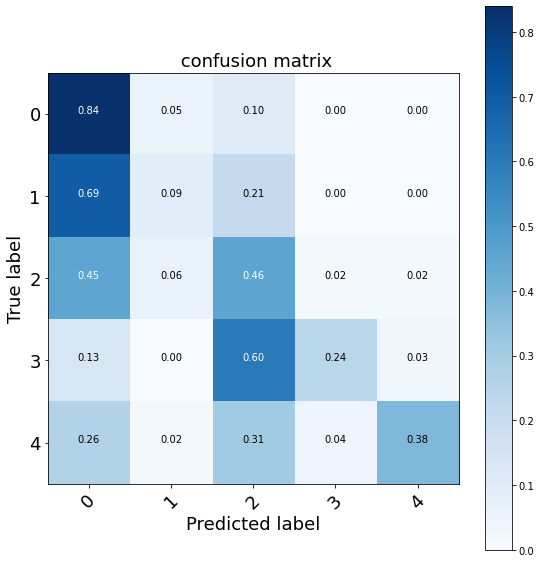

In [7]:
'''Confusion matrix'''
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=18)
    plt.yticks(tick_marks, classes,fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.tight_layout()

target_names = [ '0','1','2','3','4' ]

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(ans, pre)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,title=' confusion matrix')
# plt.savefig('Normalized confusion_matrix.jpg',dpi=300)
plt.show()